In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
from matplotlib.gridspec import GridSpec
import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv("vgsales_cleaned.csv")
import os
os.makedirs("eda_figures", exist_ok=True)
plt.rcParams.update({
    "figure.facecolor": "white",
    "axes.facecolor": "white",
    "axes.grid": True,
    "grid.alpha": 0.3,
    "grid.linestyle": "--",
    "font.family": "sans-serif",
    "font.size": 11,
    "axes.titlesize": 14,
    "axes.titleweight": "bold",
    "axes.labelsize": 12,
    "figure.dpi": 150,
})



In [5]:
PALETTE_MAIN = "#2E86AB"
PALETTE_ACCENT = "#E84855"
PALETTE_REGIONS = {"NA": "#2E86AB", "EU": "#E84855", "JP": "#F18F01", "Other": "#95BF74"}
PALETTE_TIERS = {"AAA": "#2E86AB", "Mid": "#F18F01", "Indie": "#95BF74"}


def save_fig(fig, name):
    """Save figure and print confirmation."""
    path = f"eda_figures/{name}.png"
    fig.savefig(path, bbox_inches="tight", dpi=150)
    plt.close(fig)
    print(f"  ✅ Saved: {path}")


📊 Figure 1: Sales Distribution


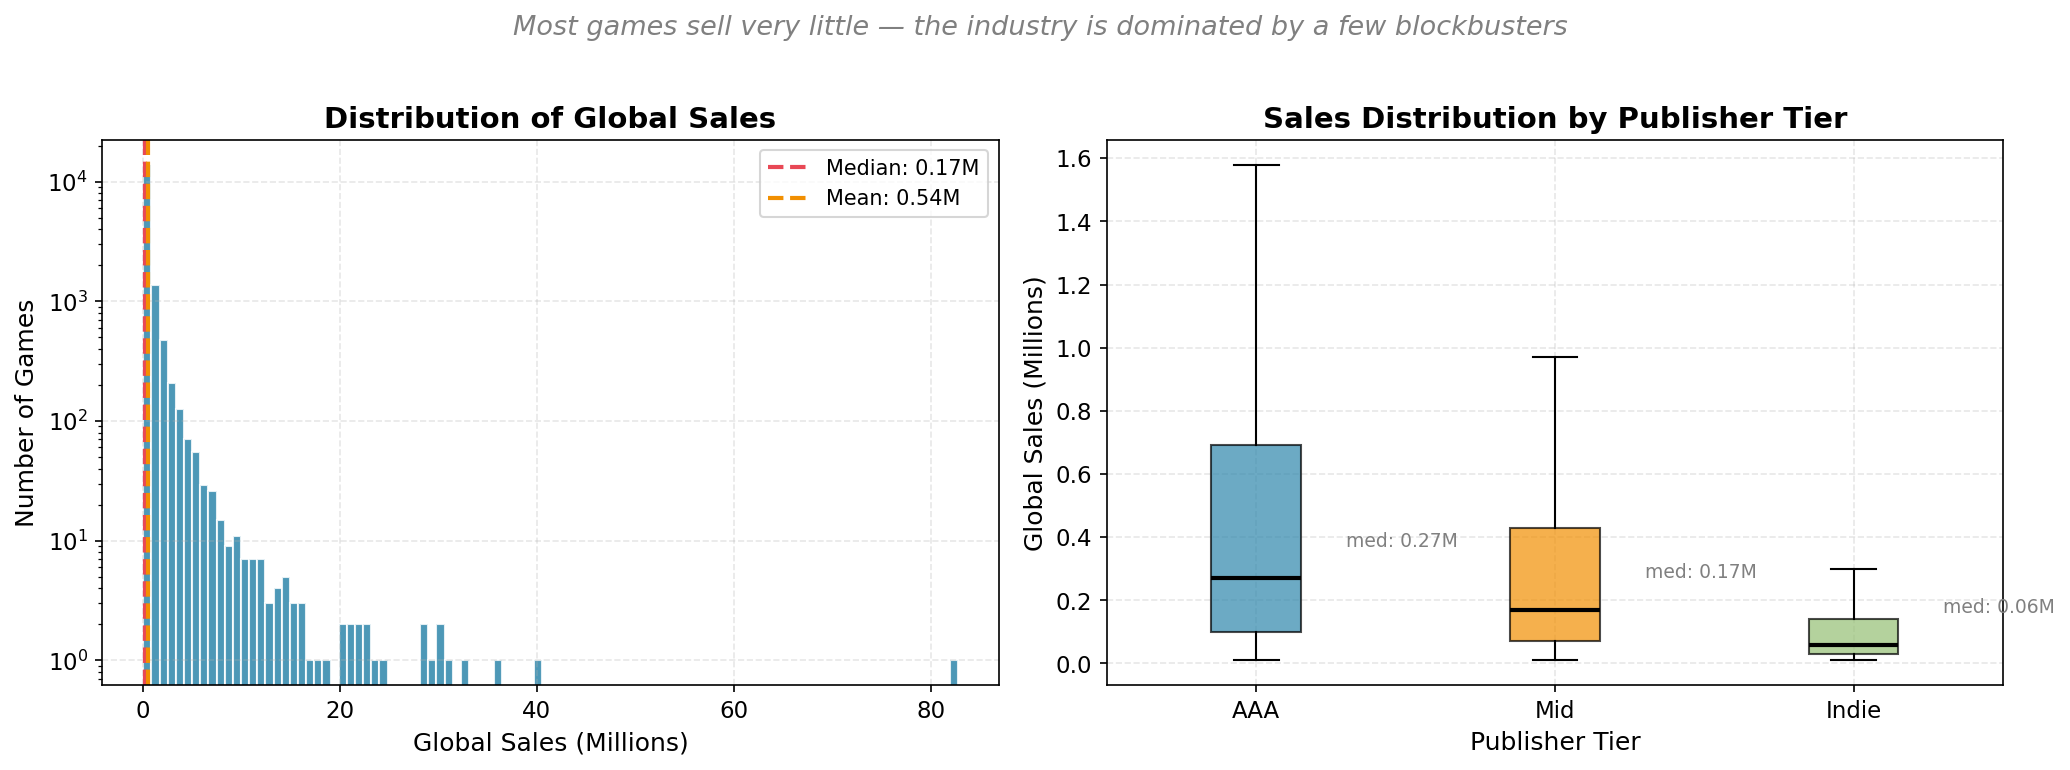

In [11]:
print("\n📊 Figure 1: Sales Distribution")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram of Global Sales (log scale)
axes[0].hist(df["Global_Sales"], bins=100, color=PALETTE_MAIN, edgecolor="white", alpha=0.85)
axes[0].set_xlabel("Global Sales (Millions)")
axes[0].set_ylabel("Number of Games")
axes[0].set_title("Distribution of Global Sales")
axes[0].set_yscale("log")
axes[0].axvline(df["Global_Sales"].median(), color=PALETTE_ACCENT, linestyle="--", linewidth=2,
                label=f'Median: {df["Global_Sales"].median():.2f}M')
axes[0].axvline(df["Global_Sales"].mean(), color="#F18F01", linestyle="--", linewidth=2,
                label=f'Mean: {df["Global_Sales"].mean():.2f}M')
axes[0].legend(fontsize=10)

# Box plot by Publisher Tier
tier_order = ["AAA", "Mid", "Indie"]
tier_colors = [PALETTE_TIERS[t] for t in tier_order]
bp_data = [df[df["Publisher_Tier"] == t]["Global_Sales"].values for t in tier_order]
bp = axes[1].boxplot(bp_data, labels=tier_order, patch_artist=True, showfliers=False,
                     medianprops=dict(color="black", linewidth=2))
for patch, color in zip(bp["boxes"], tier_colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
axes[1].set_xlabel("Publisher Tier")
axes[1].set_ylabel("Global Sales (Millions)")
axes[1].set_title("Sales Distribution by Publisher Tier")

for i, tier in enumerate(tier_order):
    med = df[df["Publisher_Tier"] == tier]["Global_Sales"].median()
    axes[1].annotate(f"med: {med:.2f}M", xy=(i + 1, med), xytext=(i + 1.3, med + 0.1),
                     fontsize=9, color="gray")

fig.suptitle("Most games sell very little — the industry is dominated by a few blockbusters",
             fontsize=13, style="italic", y=1.02, color="gray")
fig.tight_layout()
plt.show()


📊 Figure 2: Market Evolution Over Time


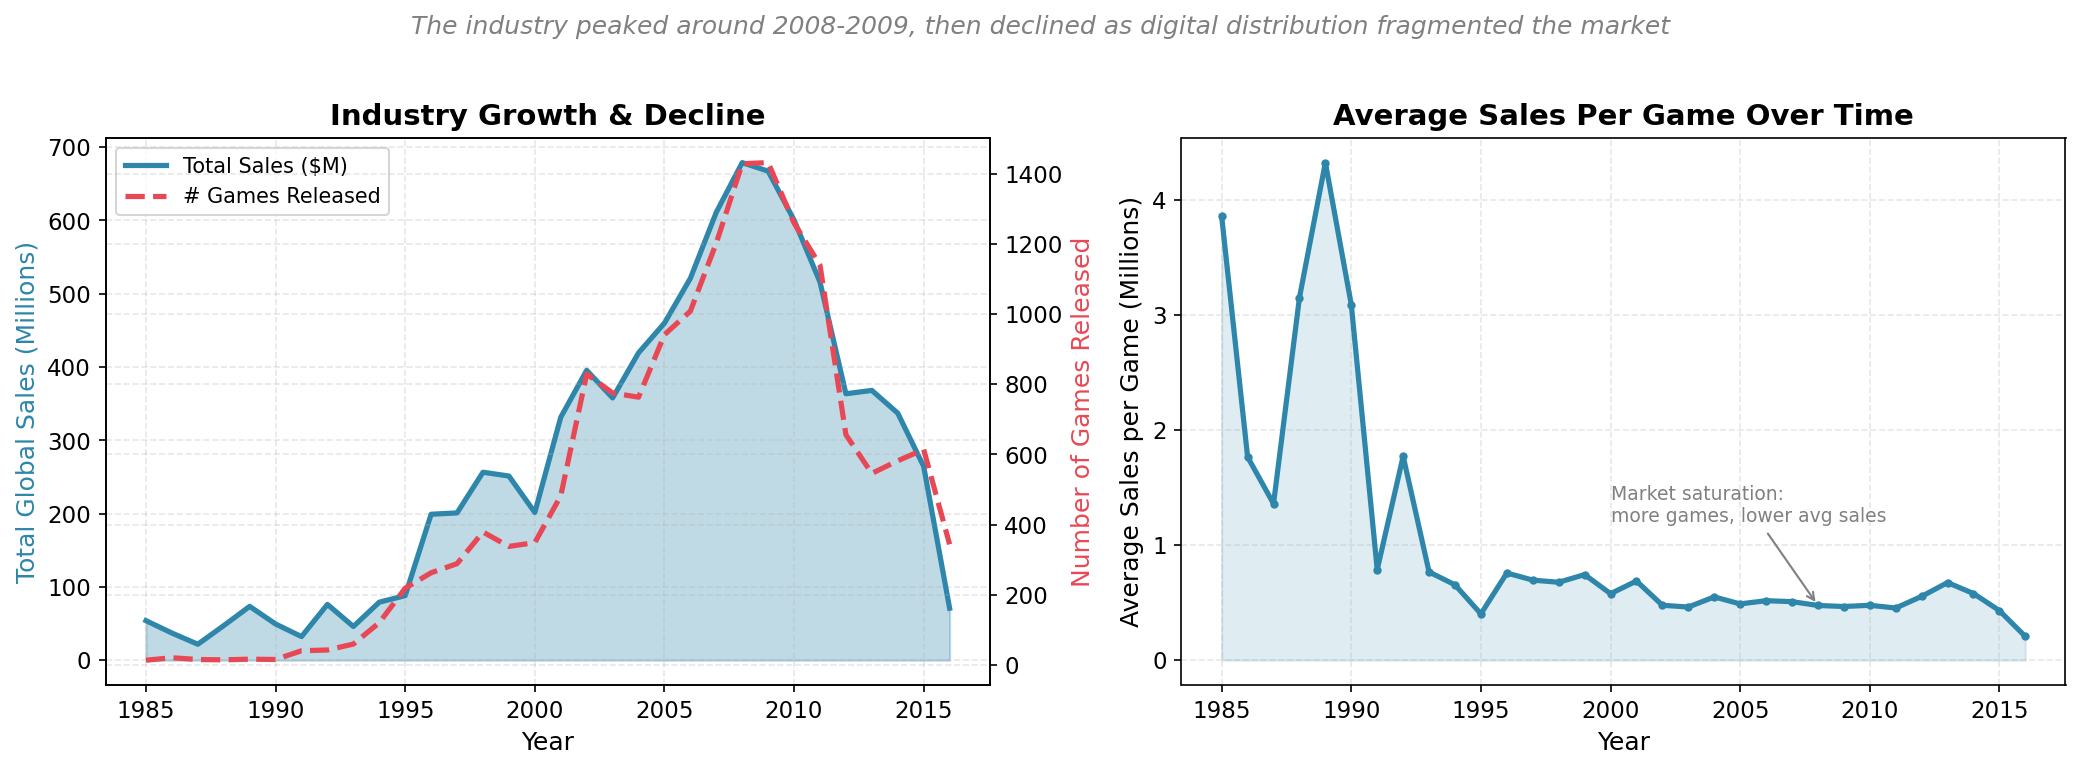

In [13]:
print("📊 Figure 2: Market Evolution Over Time")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

yearly = df.groupby("Year").agg(
    total_sales=("Global_Sales", "sum"),
    num_games=("Name", "count"),
    avg_sales=("Global_Sales", "mean")
).reset_index()

yearly = yearly[(yearly["Year"] >= 1985) & (yearly["Year"] <= 2016)]

# Total sales & game count over time (dual axis)
ax1 = axes[0]
ax2 = ax1.twinx()
ax1.fill_between(yearly["Year"], yearly["total_sales"], alpha=0.3, color=PALETTE_MAIN)
line1 = ax1.plot(yearly["Year"], yearly["total_sales"], color=PALETTE_MAIN, linewidth=2.5,
                 label="Total Sales ($M)")
line2 = ax2.plot(yearly["Year"], yearly["num_games"], color=PALETTE_ACCENT, linewidth=2.5,
                 linestyle="--", label="# Games Released")
ax1.set_xlabel("Year")
ax1.set_ylabel("Total Global Sales (Millions)", color=PALETTE_MAIN)
ax2.set_ylabel("Number of Games Released", color=PALETTE_ACCENT)
ax1.set_title("Industry Growth & Decline")

lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc="upper left", fontsize=10)

# Average sales per game over time
axes[1].plot(yearly["Year"], yearly["avg_sales"], color=PALETTE_MAIN, linewidth=2.5, marker="o",
             markersize=3)
axes[1].fill_between(yearly["Year"], yearly["avg_sales"], alpha=0.15, color=PALETTE_MAIN)
axes[1].set_xlabel("Year")
axes[1].set_ylabel("Average Sales per Game (Millions)")
axes[1].set_title("Average Sales Per Game Over Time")
axes[1].annotate("Market saturation:\nmore games, lower avg sales",
                 xy=(2008, yearly[yearly["Year"] == 2008]["avg_sales"].values[0]),
                 xytext=(2000, 1.2), fontsize=9, color="gray",
                 arrowprops=dict(arrowstyle="->", color="gray"))

fig.suptitle("The industry peaked around 2008-2009, then declined as digital distribution fragmented the market",
             fontsize=12, style="italic", y=1.02, color="gray")
fig.tight_layout()
plt.show()


📊 Figure 3: Platform Wars


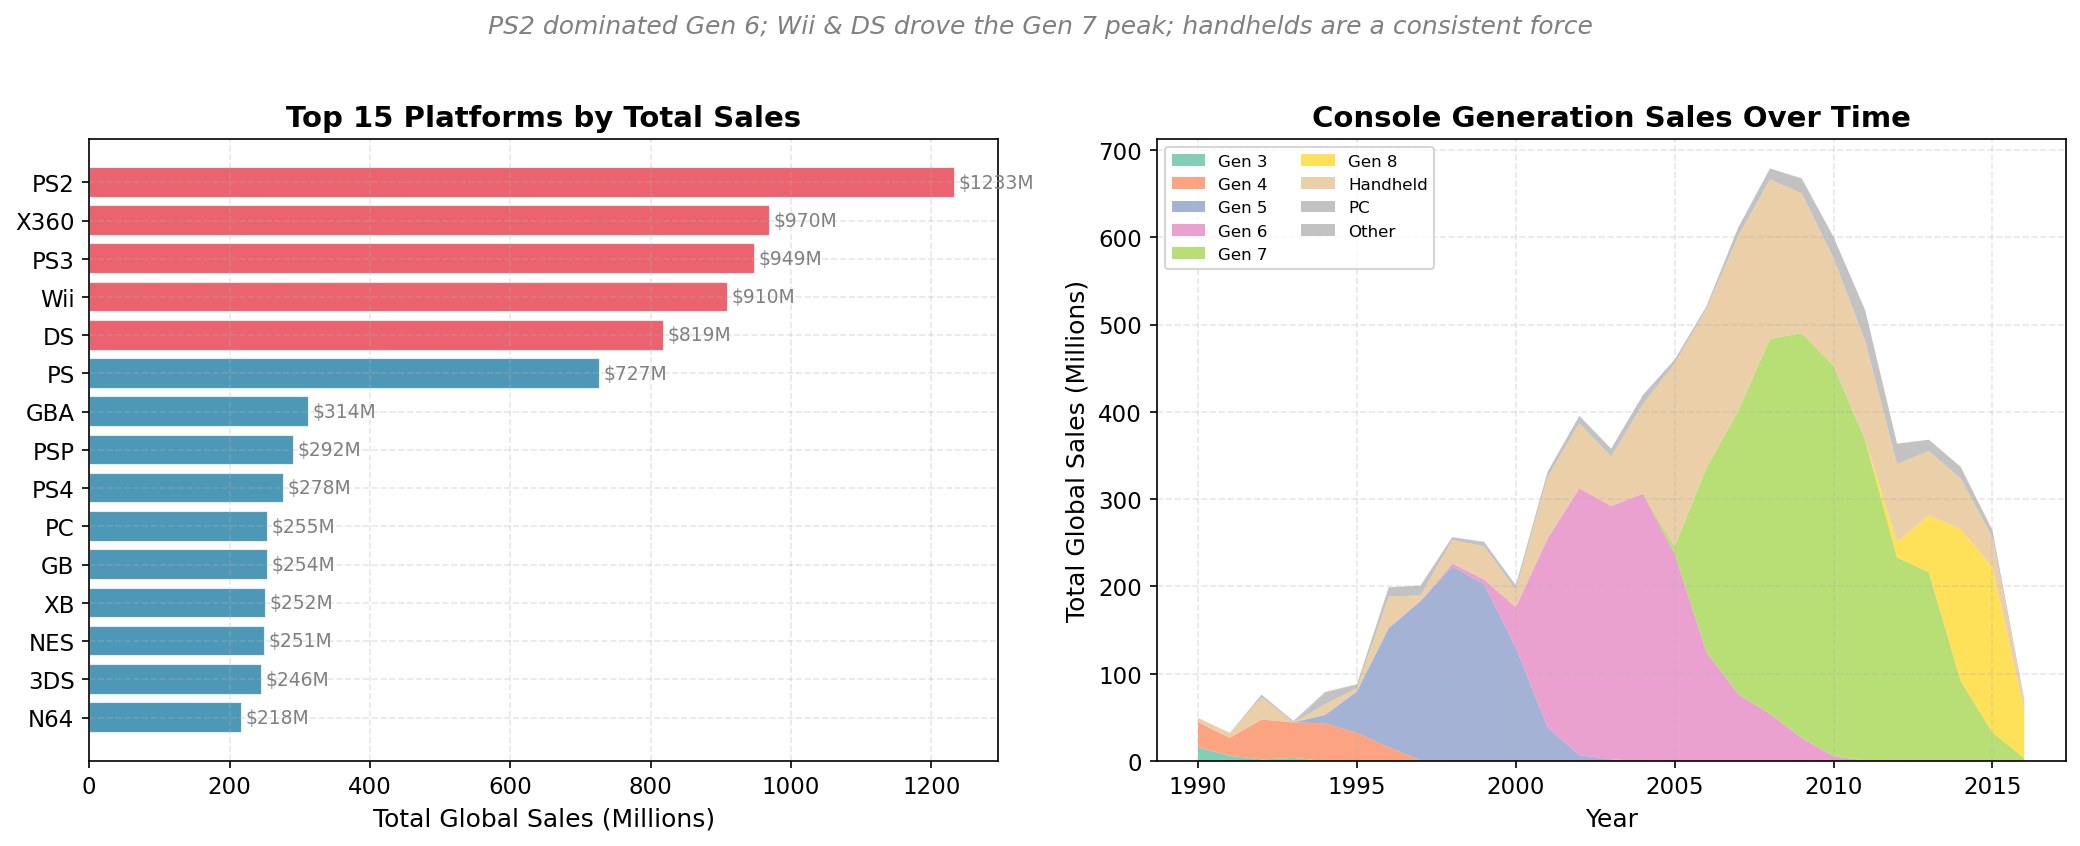

In [15]:
print("📊 Figure 3: Platform Wars")

fig, axes = plt.subplots(1, 2, figsize=(14, 5.5))

# Top platforms by total sales
platform_sales = df.groupby("Platform")["Global_Sales"].sum().sort_values(ascending=True)
top_platforms = platform_sales.tail(15)

colors = [PALETTE_ACCENT if p in ["PS2", "X360", "PS3", "Wii", "DS"] else PALETTE_MAIN
          for p in top_platforms.index]
axes[0].barh(top_platforms.index, top_platforms.values, color=colors, edgecolor="white", alpha=0.85)
axes[0].set_xlabel("Total Global Sales (Millions)")
axes[0].set_title("Top 15 Platforms by Total Sales")
for i, (val, name) in enumerate(zip(top_platforms.values, top_platforms.index)):
    axes[0].text(val + 5, i, f"${val:.0f}M", va="center", fontsize=9, color="gray")

# Platform generation market share over time
gen_yearly = df.groupby(["Year", "Platform_Gen"])["Global_Sales"].sum().unstack(fill_value=0)
gen_yearly = gen_yearly[(gen_yearly.index >= 1990) & (gen_yearly.index <= 2016)]

gen_order = ["Gen 3", "Gen 4", "Gen 5", "Gen 6", "Gen 7", "Gen 8", "Handheld", "PC", "Other"]
gen_order = [g for g in gen_order if g in gen_yearly.columns]
gen_yearly = gen_yearly[gen_order]

gen_colors = plt.cm.Set2(np.linspace(0, 1, len(gen_order)))
axes[1].stackplot(gen_yearly.index, gen_yearly.T.values, labels=gen_order,
                  colors=gen_colors, alpha=0.8)
axes[1].set_xlabel("Year")
axes[1].set_ylabel("Total Global Sales (Millions)")
axes[1].set_title("Console Generation Sales Over Time")
axes[1].legend(loc="upper left", fontsize=8, ncol=2)

fig.suptitle("PS2 dominated Gen 6; Wii & DS drove the Gen 7 peak; handhelds are a consistent force",
             fontsize=12, style="italic", y=1.02, color="gray")
fig.tight_layout()
plt.show()

📊 Figure 4: Genre Trends


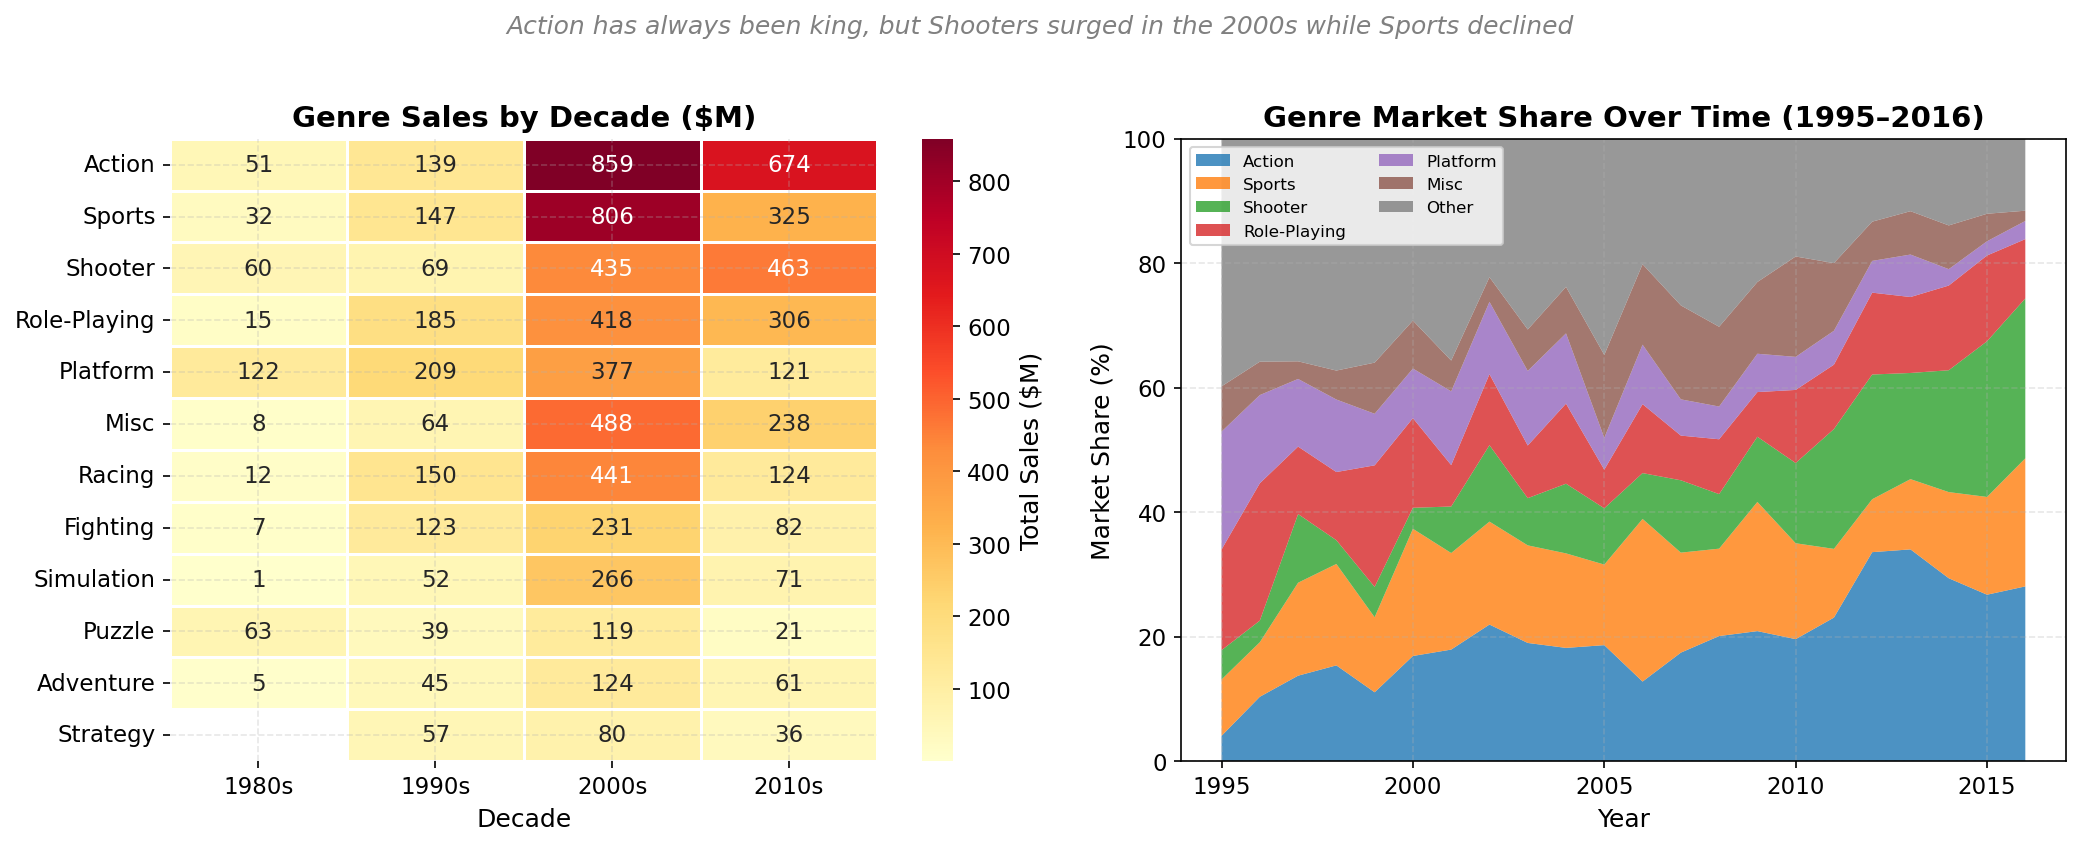

In [17]:
print("📊 Figure 4: Genre Trends")

fig, axes = plt.subplots(1, 2, figsize=(14, 5.5))

# Genre sales by decade (heatmap)
decade_order = ["1980s", "1990s", "2000s", "2010s"]
genre_decade = df[df["Decade"].isin(decade_order)].groupby(["Genre", "Decade"])["Global_Sales"].sum().unstack()
genre_decade = genre_decade[decade_order]
genre_decade = genre_decade.loc[genre_decade.sum(axis=1).sort_values(ascending=False).index]

sns.heatmap(genre_decade, annot=True, fmt=".0f", cmap="YlOrRd", ax=axes[0],
            linewidths=0.5, cbar_kws={"label": "Total Sales ($M)"})
axes[0].set_title("Genre Sales by Decade ($M)")
axes[0].set_ylabel("")

# Genre share evolution (percentage area)
genre_yearly = df[df["Year"].between(1995, 2016)].groupby(["Year", "Genre"])["Global_Sales"].sum().unstack(fill_value=0)
genre_yearly_pct = genre_yearly.div(genre_yearly.sum(axis=1), axis=0) * 100

top_genres = df.groupby("Genre")["Global_Sales"].sum().nlargest(6).index.tolist()
other_genres = [g for g in genre_yearly_pct.columns if g not in top_genres]
genre_yearly_plot = genre_yearly_pct[top_genres].copy()
genre_yearly_plot["Other"] = genre_yearly_pct[other_genres].sum(axis=1)

genre_colors = plt.cm.tab10(np.linspace(0, 0.7, len(genre_yearly_plot.columns)))
axes[1].stackplot(genre_yearly_plot.index, genre_yearly_plot.T.values,
                  labels=genre_yearly_plot.columns, colors=genre_colors, alpha=0.8)
axes[1].set_xlabel("Year")
axes[1].set_ylabel("Market Share (%)")
axes[1].set_title("Genre Market Share Over Time (1995–2016)")
axes[1].legend(loc="upper left", fontsize=8, ncol=2)
axes[1].set_ylim(0, 100)

fig.suptitle("Action has always been king, but Shooters surged in the 2000s while Sports declined",
             fontsize=12, style="italic", y=1.02, color="gray")
fig.tight_layout()
plt.show()

📊 Figure 5: Regional Preferences


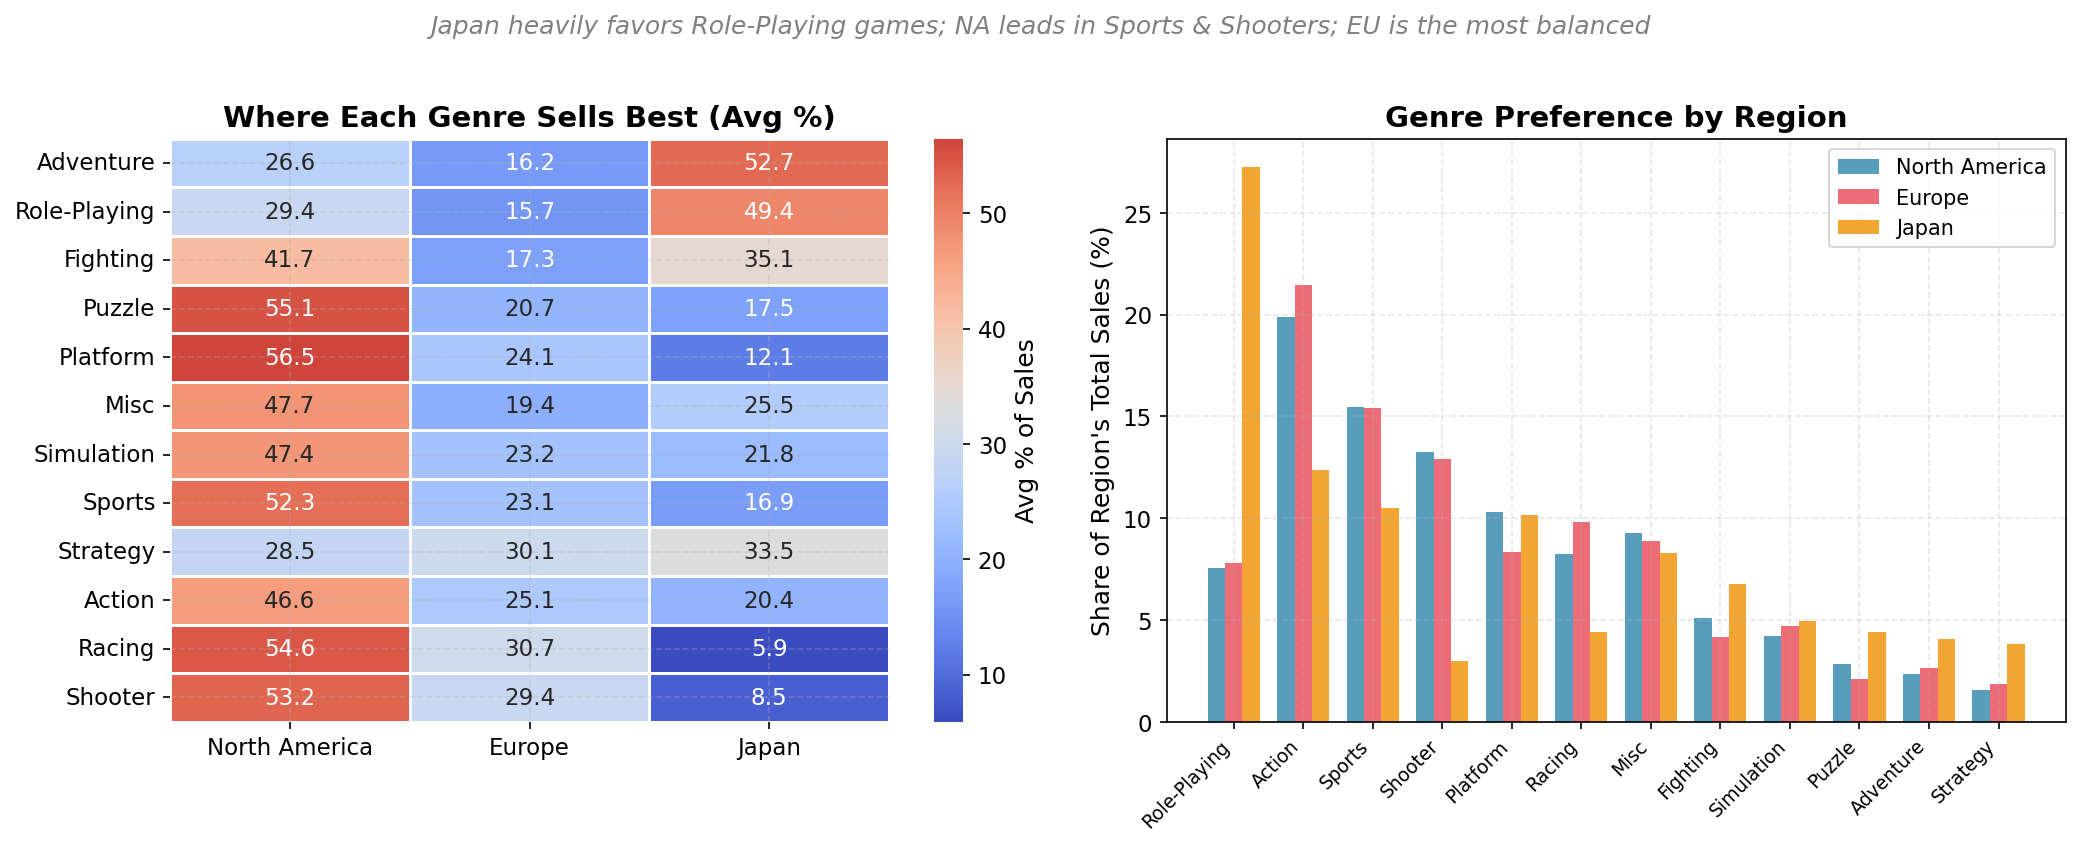

In [19]:
print("📊 Figure 5: Regional Preferences")

fig, axes = plt.subplots(1, 2, figsize=(14, 5.5))

# Heatmap: Average regional share by genre
regional_by_genre = df.groupby("Genre")[["NA_Share", "EU_Share", "JP_Share"]].mean()
regional_by_genre.columns = ["North America", "Europe", "Japan"]
regional_by_genre = regional_by_genre.loc[regional_by_genre.sum(axis=1).sort_values(ascending=False).index]

sns.heatmap(regional_by_genre, annot=True, fmt=".1f", cmap="coolwarm", ax=axes[0],
            linewidths=0.5, cbar_kws={"label": "Avg % of Sales"}, center=33.3)
axes[0].set_title("Where Each Genre Sells Best (Avg %)")
axes[0].set_ylabel("")

# Top genres per region — grouped bar chart
regions = ["NA_Sales", "EU_Sales", "JP_Sales"]
region_labels = ["North America", "Europe", "Japan"]
region_genre = df.groupby("Genre")[regions].sum()
region_genre.columns = region_labels

region_genre_pct = region_genre.div(region_genre.sum(axis=0), axis=1) * 100
region_genre_pct = region_genre_pct.loc[region_genre_pct.max(axis=1).sort_values(ascending=False).index]

x = np.arange(len(region_genre_pct))
width = 0.25
colors = [PALETTE_REGIONS["NA"], PALETTE_REGIONS["EU"], PALETTE_REGIONS["JP"]]

for i, (col, c) in enumerate(zip(region_labels, colors)):
    axes[1].bar(x + i * width, region_genre_pct[col], width, label=col, color=c, alpha=0.8)

axes[1].set_xticks(x + width)
axes[1].set_xticklabels(region_genre_pct.index, rotation=45, ha="right", fontsize=9)
axes[1].set_ylabel("Share of Region's Total Sales (%)")
axes[1].set_title("Genre Preference by Region")
axes[1].legend(fontsize=10)

fig.suptitle("Japan heavily favors Role-Playing games; NA leads in Sports & Shooters; EU is the most balanced",
             fontsize=12, style="italic", y=1.02, color="gray")
fig.tight_layout()
plt.show()

📊 Figure 6: Publisher Dominance


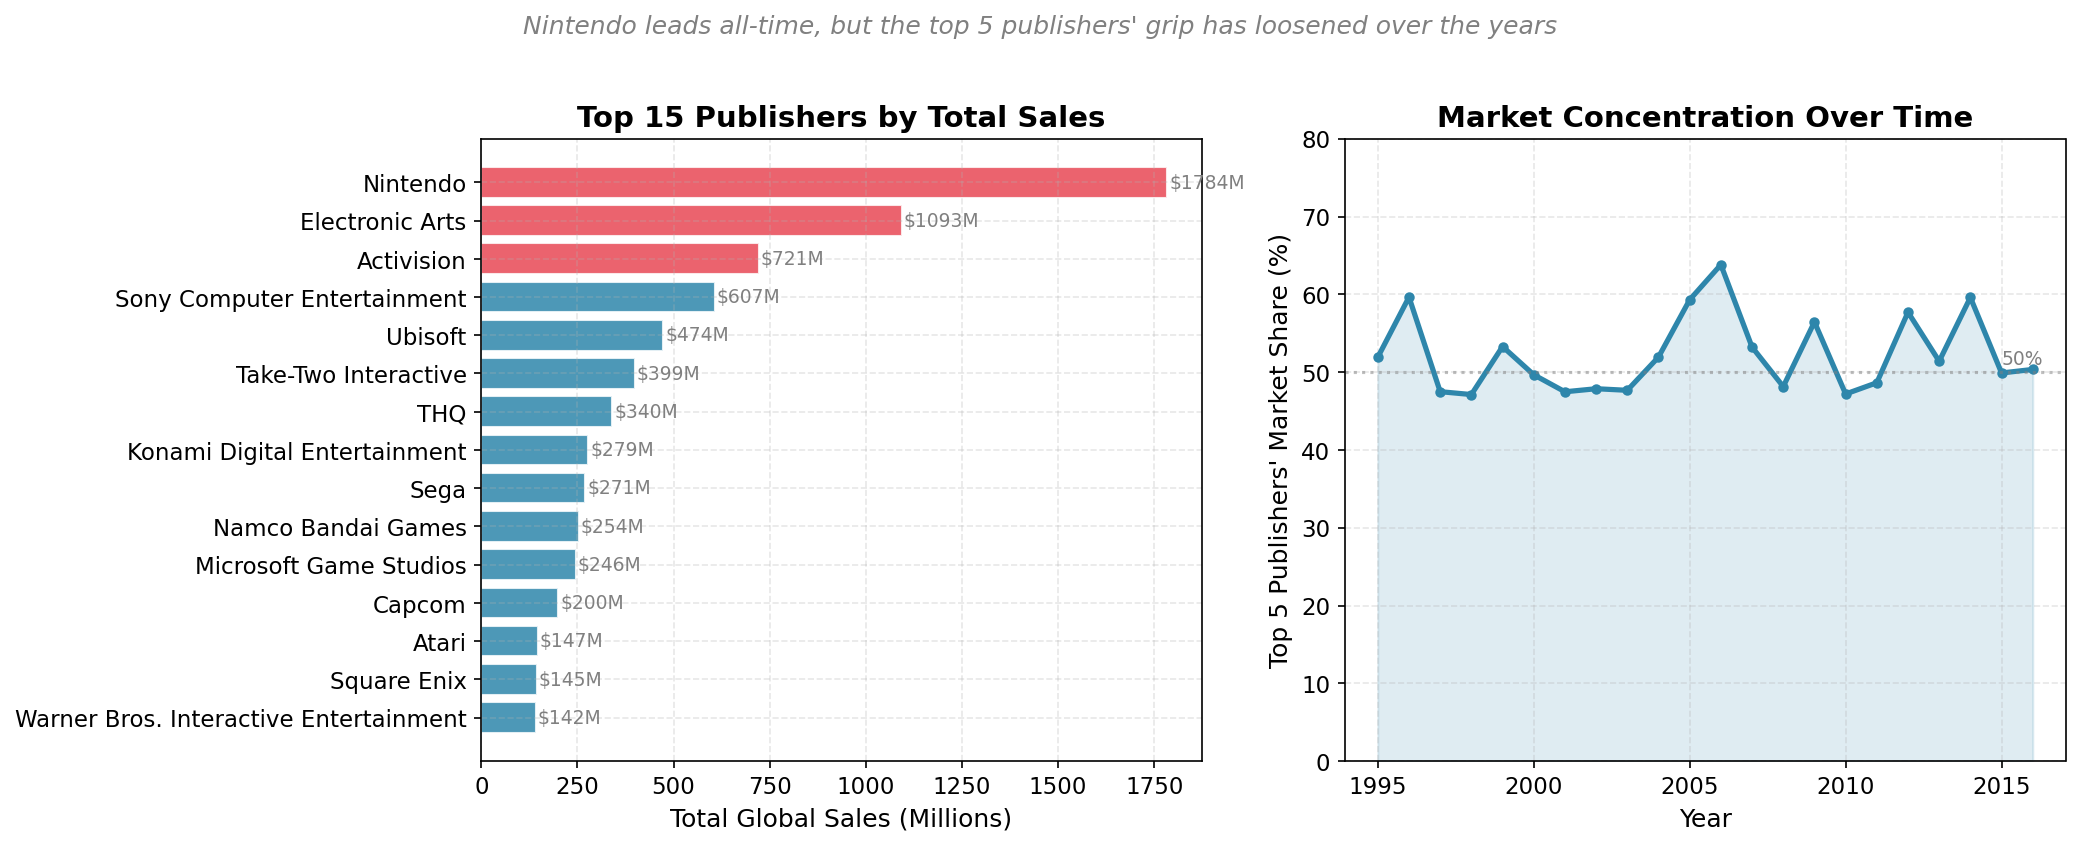

In [21]:
print("📊 Figure 6: Publisher Dominance")

fig, axes = plt.subplots(1, 2, figsize=(14, 5.5))

# Top 15 publishers
pub_sales = df.groupby("Publisher")["Global_Sales"].sum().sort_values(ascending=True).tail(15)

colors_pub = [PALETTE_ACCENT if p in ["Nintendo", "Electronic Arts", "Activision"] else PALETTE_MAIN
              for p in pub_sales.index]
axes[0].barh(pub_sales.index, pub_sales.values, color=colors_pub, edgecolor="white", alpha=0.85)
axes[0].set_xlabel("Total Global Sales (Millions)")
axes[0].set_title("Top 15 Publishers by Total Sales")
for i, val in enumerate(pub_sales.values):
    axes[0].text(val + 5, i, f"${val:.0f}M", va="center", fontsize=9, color="gray")

# Market concentration over time (top 5 publisher share)
top5_pubs = df.groupby("Publisher")["Global_Sales"].sum().nlargest(5).index.tolist()
yearly_conc = df[df["Year"].between(1995, 2016)].copy()
yearly_conc["Is_Top5"] = yearly_conc["Publisher"].isin(top5_pubs)

conc = yearly_conc.groupby("Year").apply(
    lambda x: x[x["Is_Top5"]]["Global_Sales"].sum() / x["Global_Sales"].sum() * 100
).reset_index()
conc.columns = ["Year", "Top5_Share"]

axes[1].plot(conc["Year"], conc["Top5_Share"], color=PALETTE_MAIN, linewidth=2.5, marker="o", markersize=4)
axes[1].fill_between(conc["Year"], conc["Top5_Share"], alpha=0.15, color=PALETTE_MAIN)
axes[1].set_xlabel("Year")
axes[1].set_ylabel("Top 5 Publishers' Market Share (%)")
axes[1].set_title("Market Concentration Over Time")
axes[1].set_ylim(0, 80)
axes[1].axhline(50, color="gray", linestyle=":", alpha=0.5)
axes[1].text(2015, 51, "50%", fontsize=9, color="gray")

fig.suptitle("Nintendo leads all-time, but the top 5 publishers' grip has loosened over the years",
             fontsize=12, style="italic", y=1.02, color="gray")
fig.tight_layout()
plt.show()

📊 Figure 7: Hit Rate Analysis


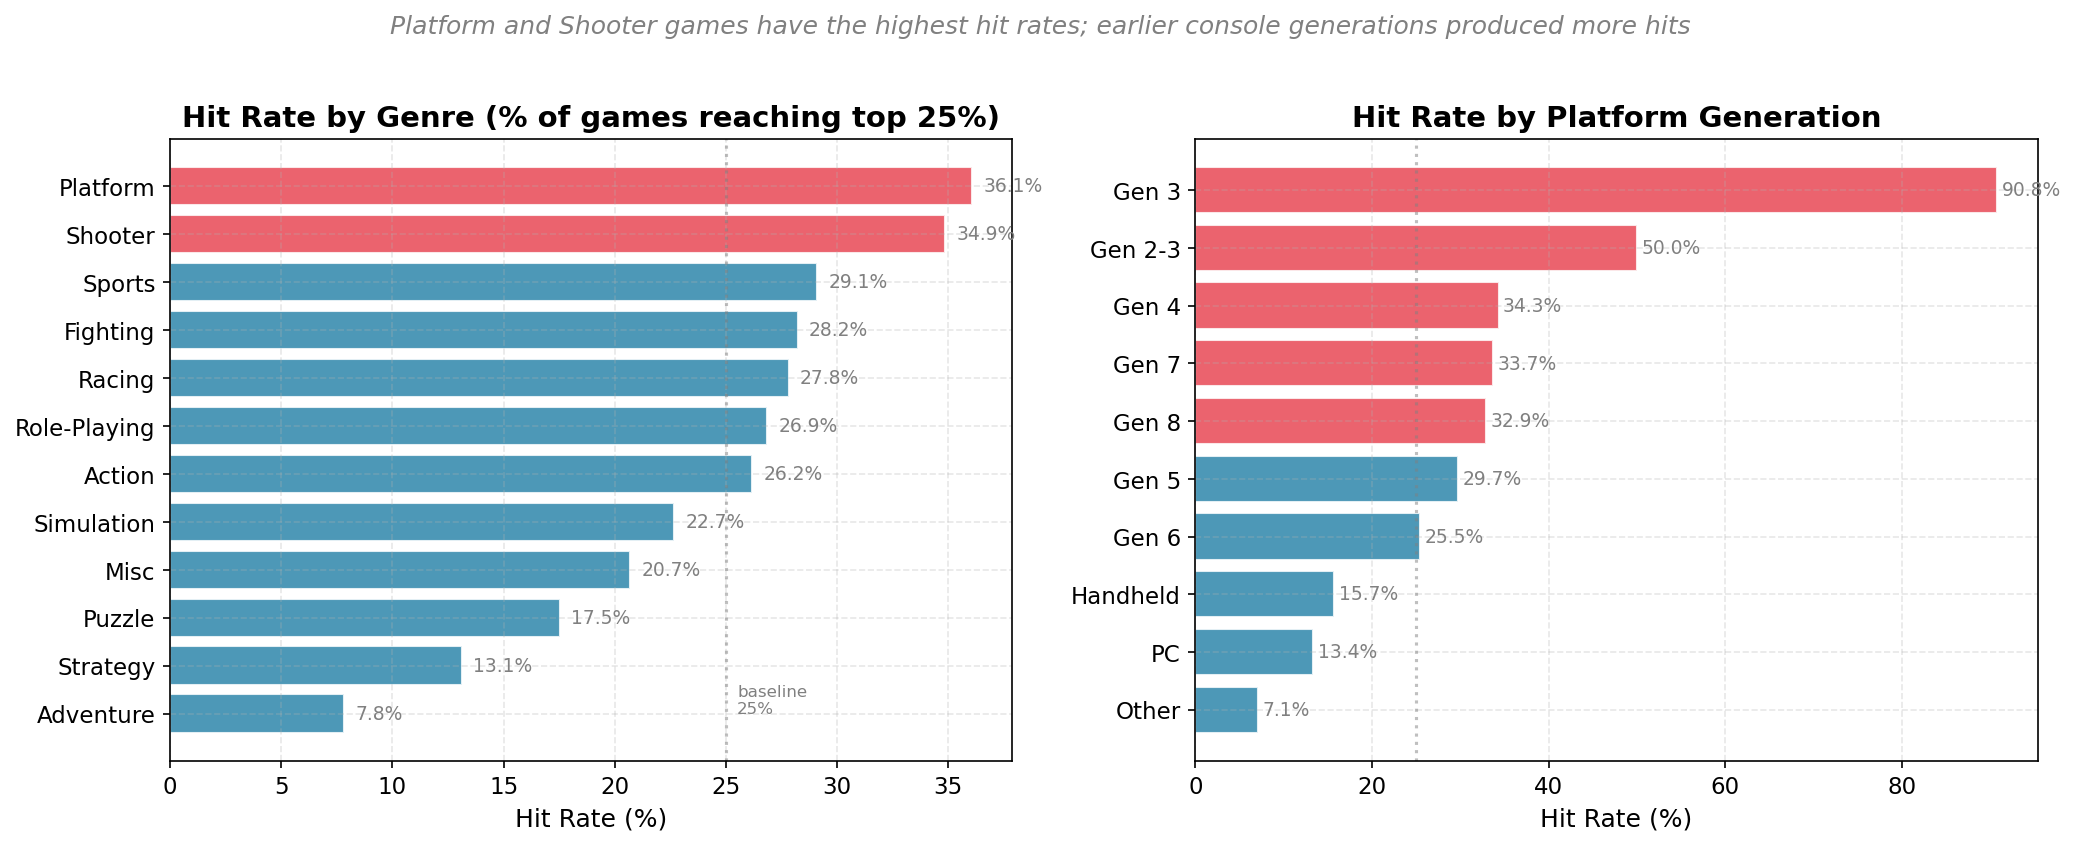

In [23]:
print("📊 Figure 7: Hit Rate Analysis")

fig, axes = plt.subplots(1, 2, figsize=(14, 5.5))

# Hit rate by genre
genre_hit = df.groupby("Genre")["Is_Hit"].mean().sort_values() * 100
colors_hit = [PALETTE_ACCENT if v > 30 else PALETTE_MAIN for v in genre_hit.values]
axes[0].barh(genre_hit.index, genre_hit.values, color=colors_hit, edgecolor="white", alpha=0.85)
axes[0].set_xlabel("Hit Rate (%)")
axes[0].set_title("Hit Rate by Genre (% of games reaching top 25%)")
axes[0].axvline(25, color="gray", linestyle=":", alpha=0.5)
axes[0].text(25.5, 0, "baseline\n25%", fontsize=8, color="gray")
for i, val in enumerate(genre_hit.values):
    axes[0].text(val + 0.5, i, f"{val:.1f}%", va="center", fontsize=9, color="gray")

# Hit rate by platform generation
gen_hit = df.groupby("Platform_Gen")["Is_Hit"].mean().sort_values() * 100
gen_order_sorted = gen_hit.index.tolist()
colors_gen = [PALETTE_ACCENT if v > 30 else PALETTE_MAIN for v in gen_hit.values]
axes[1].barh(gen_order_sorted, gen_hit.values, color=colors_gen, edgecolor="white", alpha=0.85)
axes[1].set_xlabel("Hit Rate (%)")
axes[1].set_title("Hit Rate by Platform Generation")
axes[1].axvline(25, color="gray", linestyle=":", alpha=0.5)
for i, val in enumerate(gen_hit.values):
    axes[1].text(val + 0.5, i, f"{val:.1f}%", va="center", fontsize=9, color="gray")

fig.suptitle("Platform and Shooter games have the highest hit rates; earlier console generations produced more hits",
             fontsize=12, style="italic", y=1.02, color="gray")
fig.tight_layout()
plt.show()

📊 Figure 8: Regional Correlations


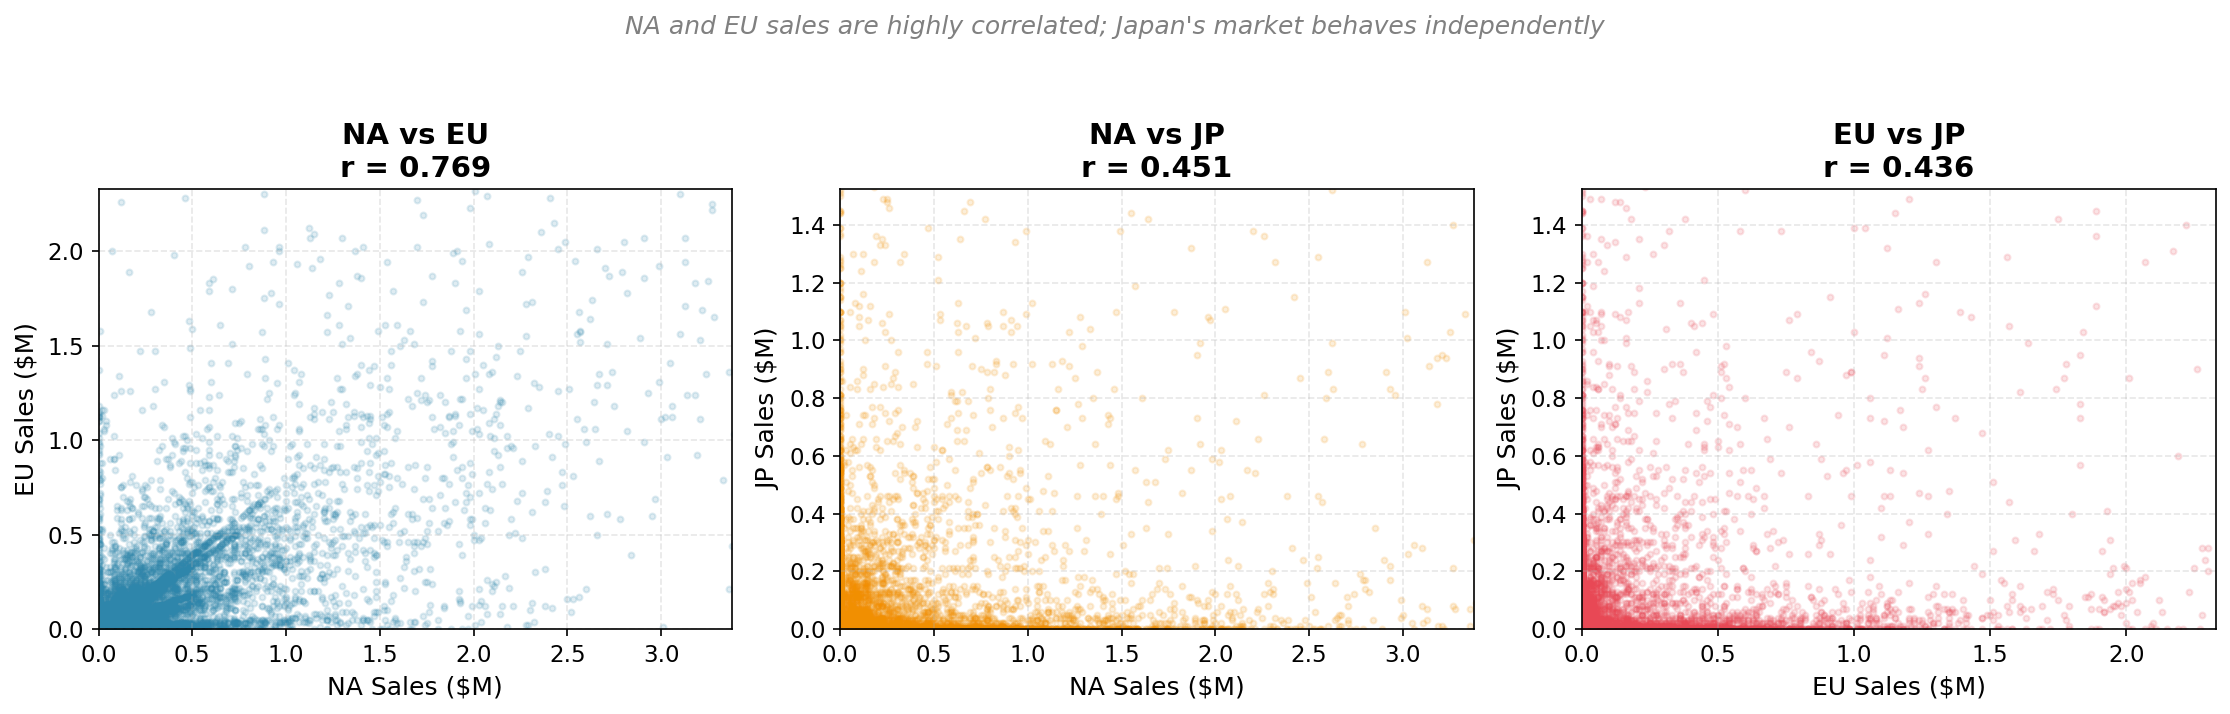

In [25]:
print("📊 Figure 8: Regional Correlations")

fig, axes = plt.subplots(1, 3, figsize=(15, 4.5))

pairs = [("NA_Sales", "EU_Sales", "NA vs EU"),
         ("NA_Sales", "JP_Sales", "NA vs JP"),
         ("EU_Sales", "JP_Sales", "EU vs JP")]
pair_colors = [PALETTE_REGIONS["NA"], PALETTE_REGIONS["JP"], PALETTE_REGIONS["EU"]]

for ax, (x, y, title), c in zip(axes, pairs, pair_colors):
    ax.scatter(df[x], df[y], alpha=0.15, s=8, color=c)
    corr = df[x].corr(df[y])
    ax.set_xlabel(f"{x.replace('_', ' ')} ($M)")
    ax.set_ylabel(f"{y.replace('_', ' ')} ($M)")
    ax.set_title(f"{title}\nr = {corr:.3f}")

    # Limit axes for readability (exclude extreme outliers)
    ax.set_xlim(0, df[x].quantile(0.99) * 1.2)
    ax.set_ylim(0, df[y].quantile(0.99) * 1.2)

fig.suptitle("NA and EU sales are highly correlated; Japan's market behaves independently",
             fontsize=12, style="italic", y=1.05, color="gray")
fig.tight_layout()
plt.show()

📊 Figure 9: Top Games Deep Dive


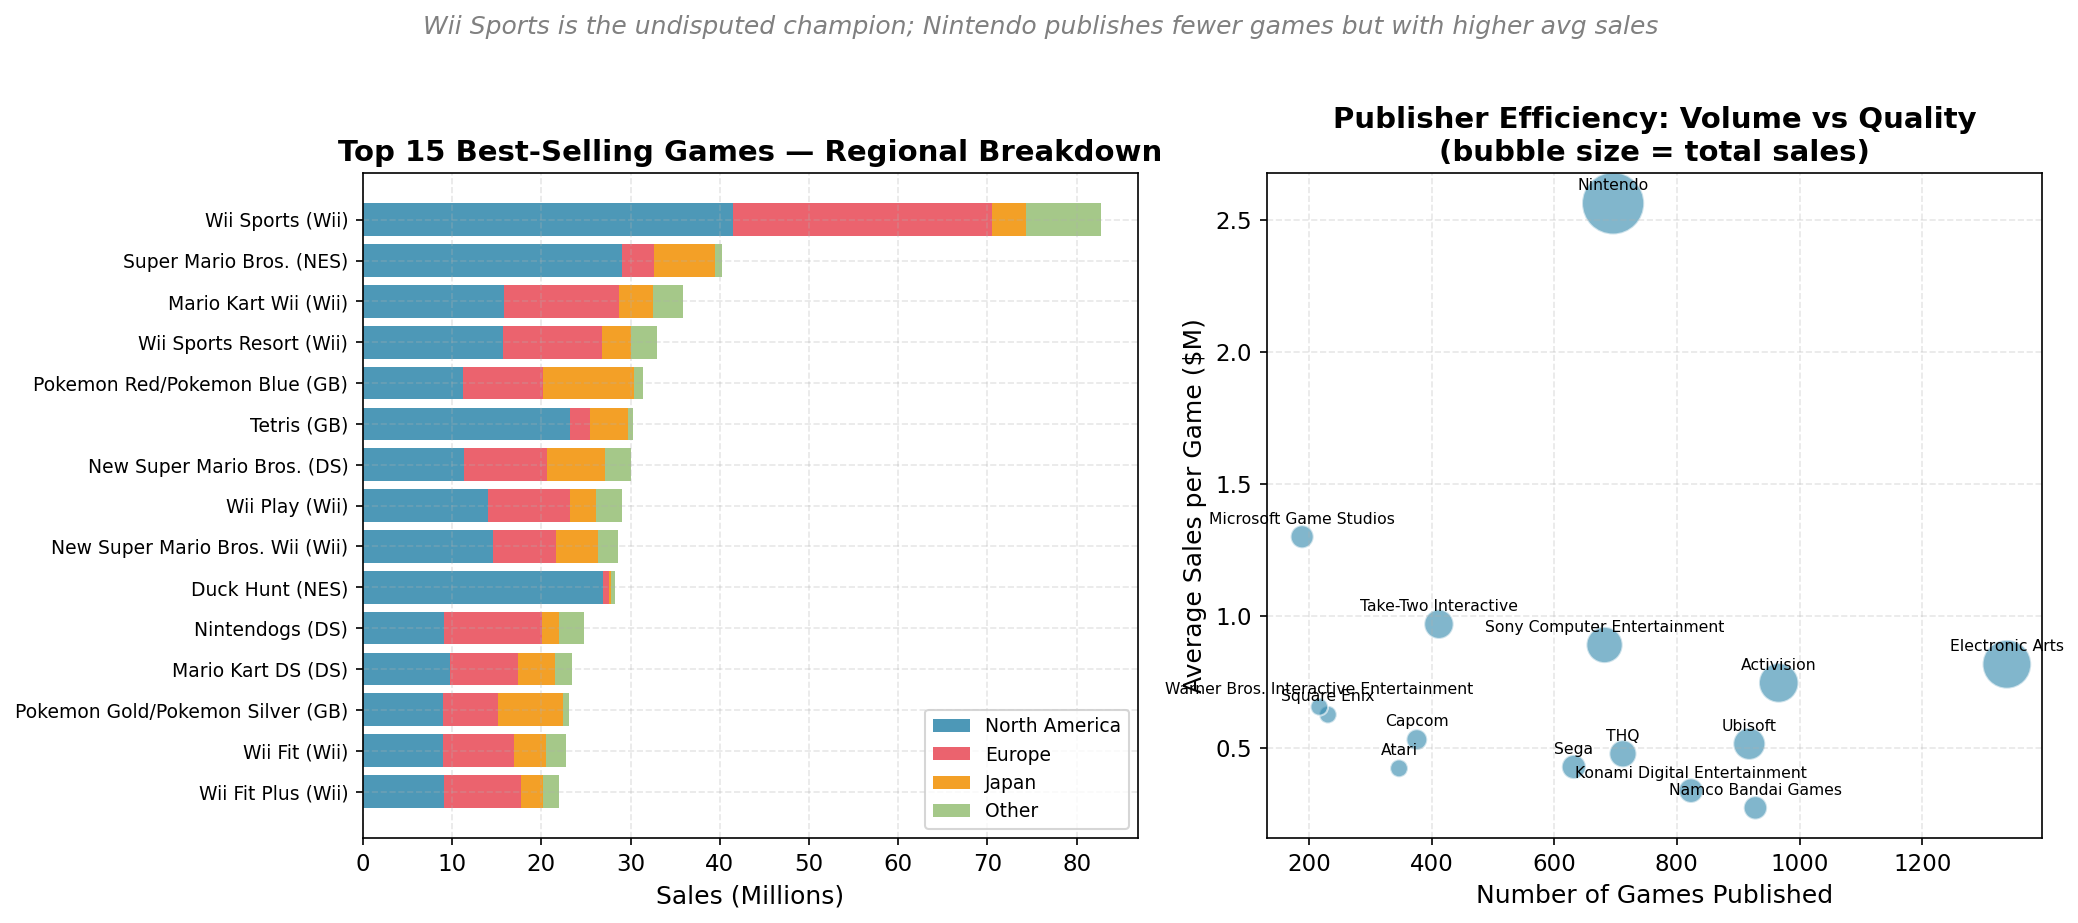

In [27]:
print("📊 Figure 9: Top Games Deep Dive")

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Top 15 games — stacked bar by region
top15 = df.nlargest(15, "Global_Sales").sort_values("Global_Sales")
regions_cols = ["NA_Sales", "EU_Sales", "JP_Sales", "Other_Sales"]
region_names = ["North America", "Europe", "Japan", "Other"]
region_colors = [PALETTE_REGIONS["NA"], PALETTE_REGIONS["EU"], PALETTE_REGIONS["JP"], PALETTE_REGIONS["Other"]]

left = np.zeros(len(top15))
for col, name, c in zip(regions_cols, region_names, region_colors):
    axes[0].barh(range(len(top15)), top15[col].values, left=left, label=name, color=c, alpha=0.85)
    left += top15[col].values

axes[0].set_yticks(range(len(top15)))
axes[0].set_yticklabels([f"{n} ({p})" for n, p in zip(top15["Name"], top15["Platform"])], fontsize=9)
axes[0].set_xlabel("Sales (Millions)")
axes[0].set_title("Top 15 Best-Selling Games — Regional Breakdown")
axes[0].legend(loc="lower right", fontsize=9)

# Top 10 publishers: avg sales vs number of games (bubble chart)
pub_stats = df.groupby("Publisher").agg(
    avg_sales=("Global_Sales", "mean"),
    total_sales=("Global_Sales", "sum"),
    num_games=("Name", "count")
).reset_index()
pub_stats = pub_stats[pub_stats["num_games"] >= 20]  # filter to meaningful publishers
pub_top = pub_stats.nlargest(15, "total_sales")

scatter = axes[1].scatter(pub_top["num_games"], pub_top["avg_sales"],
                          s=pub_top["total_sales"] * 0.5, alpha=0.6, c=PALETTE_MAIN,
                          edgecolor="white", linewidth=1)
for _, row in pub_top.iterrows():
    axes[1].annotate(row["Publisher"], (row["num_games"], row["avg_sales"]),
                     fontsize=7.5, ha="center", va="bottom",
                     xytext=(0, 5), textcoords="offset points")
axes[1].set_xlabel("Number of Games Published")
axes[1].set_ylabel("Average Sales per Game ($M)")
axes[1].set_title("Publisher Efficiency: Volume vs Quality\n(bubble size = total sales)")

fig.suptitle("Wii Sports is the undisputed champion; Nintendo publishes fewer games but with higher avg sales",
             fontsize=12, style="italic", y=1.02, color="gray")
fig.tight_layout()
plt.show()

📊 Figure 10: Summary Dashboard


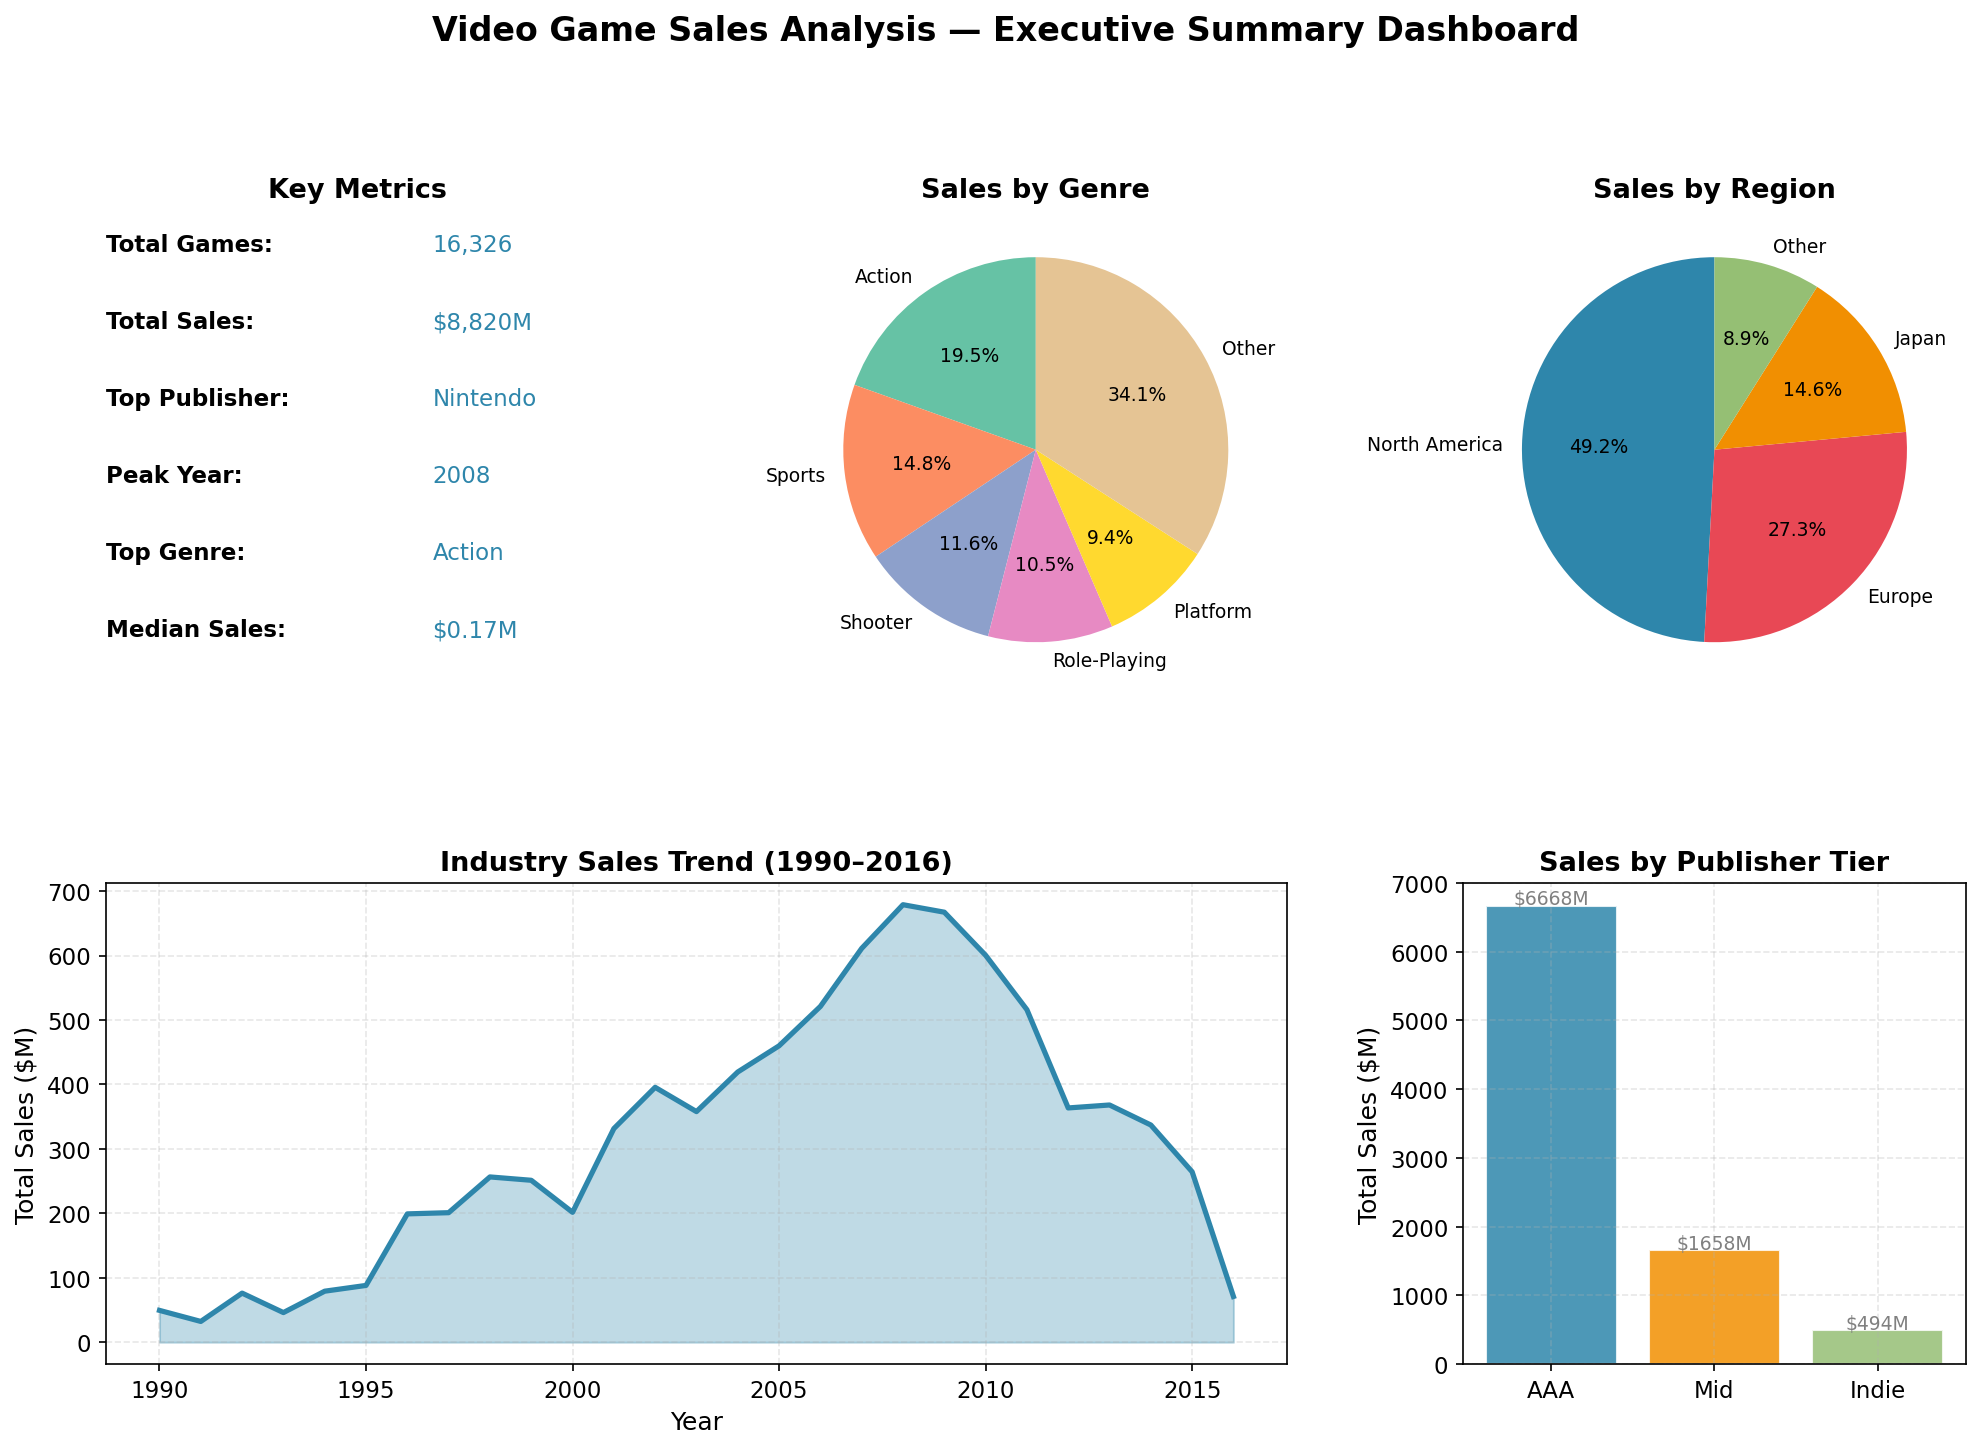

In [29]:
print("📊 Figure 10: Summary Dashboard")

fig = plt.figure(figsize=(16, 10))
gs = GridSpec(2, 3, figure=fig, hspace=0.4, wspace=0.35)

# 10a. KPI cards (top row, spanning full width)
ax_kpi = fig.add_subplot(gs[0, 0])
kpis = {
    "Total Games": f"{len(df):,}",
    "Total Sales": f"${df['Global_Sales'].sum():,.0f}M",
    "Top Publisher": "Nintendo",
    "Peak Year": "2008",
    "Top Genre": "Action",
    "Median Sales": f"${df['Global_Sales'].median():.2f}M",
}
ax_kpi.axis("off")
y_pos = 0.95
for label, value in kpis.items():
    ax_kpi.text(0.0, y_pos, label + ":", fontsize=11, fontweight="bold",
                transform=ax_kpi.transAxes, va="top")
    ax_kpi.text(0.65, y_pos, value, fontsize=11, color=PALETTE_MAIN,
                transform=ax_kpi.transAxes, va="top")
    y_pos -= 0.16
ax_kpi.set_title("Key Metrics", fontsize=13, fontweight="bold")

# 10b. Sales by genre (pie)
ax_pie = fig.add_subplot(gs[0, 1])
genre_sales = df.groupby("Genre")["Global_Sales"].sum().sort_values(ascending=False)
top5_genre = genre_sales.head(5)
top5_genre["Other"] = genre_sales.tail(len(genre_sales) - 5).sum()
wedge_colors = plt.cm.Set2(np.linspace(0, 0.8, len(top5_genre)))
ax_pie.pie(top5_genre, labels=top5_genre.index, autopct="%1.1f%%", startangle=90,
           colors=wedge_colors, textprops={"fontsize": 9})
ax_pie.set_title("Sales by Genre", fontsize=13, fontweight="bold")

# 10c. Regional split (pie)
ax_region = fig.add_subplot(gs[0, 2])
region_totals = df[["NA_Sales", "EU_Sales", "JP_Sales", "Other_Sales"]].sum()
region_totals.index = ["North America", "Europe", "Japan", "Other"]
r_colors = [PALETTE_REGIONS[k] for k in ["NA", "EU", "JP", "Other"]]
ax_region.pie(region_totals, labels=region_totals.index, autopct="%1.1f%%", startangle=90,
              colors=r_colors, textprops={"fontsize": 9})
ax_region.set_title("Sales by Region", fontsize=13, fontweight="bold")

# 10d. Sales trend
ax_trend = fig.add_subplot(gs[1, 0:2])
yr = df.groupby("Year")["Global_Sales"].sum().reset_index()
yr = yr[(yr["Year"] >= 1990) & (yr["Year"] <= 2016)]
ax_trend.fill_between(yr["Year"], yr["Global_Sales"], alpha=0.3, color=PALETTE_MAIN)
ax_trend.plot(yr["Year"], yr["Global_Sales"], color=PALETTE_MAIN, linewidth=2.5)
ax_trend.set_xlabel("Year")
ax_trend.set_ylabel("Total Sales ($M)")
ax_trend.set_title("Industry Sales Trend (1990–2016)", fontsize=13, fontweight="bold")

# 10e. Publisher tier breakdown
ax_tier = fig.add_subplot(gs[1, 2])
tier_data = df.groupby("Publisher_Tier")["Global_Sales"].sum()
tier_data = tier_data.reindex(["AAA", "Mid", "Indie"])
t_colors = [PALETTE_TIERS[t] for t in tier_data.index]
bars = ax_tier.bar(tier_data.index, tier_data.values, color=t_colors, edgecolor="white", alpha=0.85)
ax_tier.set_ylabel("Total Sales ($M)")
ax_tier.set_title("Sales by Publisher Tier", fontsize=13, fontweight="bold")
for bar, val in zip(bars, tier_data.values):
    ax_tier.text(bar.get_x() + bar.get_width() / 2, val + 20, f"${val:.0f}M",
                 ha="center", fontsize=9, color="gray")

fig.suptitle("Video Game Sales Analysis — Executive Summary Dashboard",
             fontsize=16, fontweight="bold", y=1.01)
plt.show()

In [31]:
print("\n" + "=" * 60)
print("KEY INSIGHTS FROM EDA")
print("=" * 60)

total_sales = df["Global_Sales"].sum()
peak_year_sales = df.groupby("Year")["Global_Sales"].sum().max()
peak_year = df.groupby("Year")["Global_Sales"].sum().idxmax()
na_eu_corr = df["NA_Sales"].corr(df["EU_Sales"])
na_jp_corr = df["NA_Sales"].corr(df["JP_Sales"])

insights = [
    f"1. MARKET SIZE: {len(df):,} games generated ${total_sales:,.0f}M in sales, "
    f"but the median game sold only ${df['Global_Sales'].median():.2f}M.",

    f"2. PEAK & DECLINE: Industry peaked in {peak_year} (${peak_year_sales:,.0f}M), "
    f"then declined as the market fragmented with digital distribution.",

    f"3. PLATFORM DOMINANCE: PS2 is the all-time leader in total sales, "
    f"but Gen 7 (Wii/X360/PS3) was the most successful generation overall.",

    f"4. GENRE EVOLUTION: Action has always led, but Shooters rose from ~5% to ~20% "
    f"market share between 2000–2010. Sports declined as a share.",

    f"5. REGIONAL DIVIDE: NA–EU correlation is strong (r={na_eu_corr:.2f}), "
    f"but JP is independent (r={na_jp_corr:.2f} with NA). "
    f"Japan uniquely favors RPGs ({df[df['Genre']=='Role-Playing']['JP_Share'].mean():.0f}% JP share avg).",

    f"6. PUBLISHER CONCENTRATION: Nintendo leads all-time (${df[df['Publisher']=='Nintendo']['Global_Sales'].sum():,.0f}M) "
    f"with higher per-game averages than EA or Activision.",

    f"7. HIT RATES: Platform and Shooter genres have the highest hit rates (>30%), "
    f"while Strategy and Adventure are below 20%.",
]



KEY INSIGHTS FROM EDA

1. MARKET SIZE: 16,326 games generated $8,820M in sales, but the median game sold only $0.17M.

2. PEAK & DECLINE: Industry peaked in 2008 ($679M), then declined as the market fragmented with digital distribution.

3. PLATFORM DOMINANCE: PS2 is the all-time leader in total sales, but Gen 7 (Wii/X360/PS3) was the most successful generation overall.

4. GENRE EVOLUTION: Action has always led, but Shooters rose from ~5% to ~20% market share between 2000–2010. Sports declined as a share.

5. REGIONAL DIVIDE: NA–EU correlation is strong (r=0.77), but JP is independent (r=0.45 with NA). Japan uniquely favors RPGs (49% JP share avg).

6. PUBLISHER CONCENTRATION: Nintendo leads all-time ($1,784M) with higher per-game averages than EA or Activision.

7. HIT RATES: Platform and Shooter genres have the highest hit rates (>30%), while Strategy and Adventure are below 20%.

📊 All 10 figures displayed above.
